# Assess the Output of a Saved Model

This notebook allows you to load the weights of a trained U-Net model, pass data to it, and turn the model's output back in to audio, for subjective assesment against the original mixed and isolated signals.

In [41]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf
import mir_eval
import importlib
from datetime import datetime

import audio_functions as af
import audio_models
import dataset

In [28]:
importlib.reload(audio_models)

<module 'audio_models' from '/home/enterprise.internal.city.ac.uk/acvn728/MScFinalProject/audio_models.py'>

### Get the variables and data ready

In [28]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=True
batch_size = 5
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0002

#checkpoint = '52/52-10' #  Best U-net
checkpoint = '162/162-8'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

#directory_a = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Voice/train-clean-100/19/198/'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/minimini/Mixed/train-clean-100/19/198/'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/minimini/Voice/train-clean-100/19/198/'

#directory_a = '/data/Speech_Data/LibriSpeech/Mixed/test-clean/1580/141083/'
#directory_b = '/data/Speech_Data/LibriSpeech/Voice/test-clean/1580/141083/'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)

#  Create the iterator
pipe = data.make_initializable_iterator()
mixed_spec, voice_spec, mixed_audio, voice_audio = pipe.get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 0], 3)

mixed_input = mixed_spec[:, :, :-1, 2:4]
voice_input = voice_spec[:, :, :-1, 2:4]

data

<PrefetchDataset shapes: ((?, 256, 513, 4), (?, 256, 513, 4), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

### Define the model structure

In [29]:
# Build U-Net model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_input, voice_input, mixed_phase, mixed_audio, 
                                    voice_audio, 'unet', is_training, learning_rate, 
                                    'mag_phase', name='Magnitude_Model')
tf_config = tf.ConfigProto()
#tf_config.gpu_options.allow_growth = True
tf_config.gpu_options.visible_device_list = str(0)
sess = tf.Session(config=tf_config)
sess.run(tf.global_variables_initializer())

Creating model


In [30]:
model.voice_mask_network.decoder.output.shape

TensorShape([Dimension(None), Dimension(256), Dimension(512), Dimension(2)])

### Load the saved weights - Skip this cell to hear results from a randomly initialised network

In [31]:

print('Loading checkpoint')
checkpoint_path = os.path.join(model_base_dir, checkpoint)
restorer = tf.train.Saver()
restorer.restore(sess, checkpoint_path)

Loading checkpoint
INFO:tensorflow:Restoring parameters from /home/enterprise.internal.city.ac.uk/acvn728/checkpoints/162/162-8


### Run a batch

In [43]:
sess.run(pipe.initializer)
mix_inp, mix_phase, voice_inp, voice_est, mask, voice_wave, mix_wave = sess.run([model.mixed_input, 
                                                                                 model.mixed_phase, 
                                                                                 model.voice_input,
                                                                                 model.gen_voice, 
                                                                                 model.voice_mask, 
                                                                                 model.voice_audio, 
                                                                                 model.mixed_audio],
                                                                                {model.is_training:False})
voice_est_wave = np.empty(voice_wave.shape)

for i in range(voice_inp.shape[0]):
    wave = af.spectrogramToAudioFile(np.squeeze(voice_est[i, :, :, 0]).T, n_fft,
                                     fft_hop, phaseIterations=0, phase=np.squeeze(voice_est[i, :, :, 1]).T)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)


### Visualise and Listen to the output

The output will consist of up to [batch_size] clips from a single recording.

In [44]:
i=1
x = range(len(voice_est_wave[i]))
print(len(voice_est_wave))
print(len(voice_est_wave[0]))

5
65280


In [45]:
# Infer the background noise and background noise estimate by subtracting the voice and voice estimate from the mixture
# Normalise audio prior to subtraction
def normalise_audio(audio):
    norm_audio = 2*((audio - audio.min())/(audio.max()-audio.min())) - 1
    return norm_audio

for i in range (voice_wave.shape[0]):
    voice_wave[i,:,:] = normalise_audio(voice_wave[i,:,:])
    voice_est_wave[i,:,:] = normalise_audio(voice_est_wave[i,:,:])
    mix_wave[i,:,:] = normalise_audio(mix_wave[i,:,:])

bg_ref_wave = mix_wave - voice_wave
bg_est_wave = mix_wave - voice_est_wave

In [46]:
# Calculate audio metrics for the batch
ref_sources = []
est_sources = []
mixed_sources = []
sdrs = np.empty((0, 2))
sirs = np.empty((0, 2))
sars = np.empty((0, 2))
nsdrs = np.empty((0, 2))
for i in range(len(voice_est_wave)):
    ref_sources.append(np.concatenate((voice_wave[i], bg_ref_wave[i]), axis=1))
    est_sources.append(np.concatenate((voice_est_wave[i], bg_est_wave[i]), axis=1))
    mixed_sources.append(np.concatenate((mix_wave[i], mix_wave[i]), axis=1))
    sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, est_sources[i].T, compute_permutation=False)
    sdr_mr, _, _, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, mixed_sources[i].T, compute_permutation=False)
    nsdr = sdr - sdr_mr
    sdrs = np.concatenate((sdrs, np.expand_dims(sdr, 1).T), axis=0)
    sirs = np.concatenate((sirs, np.expand_dims(sir, 1).T), axis=0)
    sars = np.concatenate((sars, np.expand_dims(sar, 1).T), axis=0)
    nsdrs = np.concatenate((nsdrs, np.expand_dims(nsdr, 1).T), axis=0)

print('Metrics (voice, background):\nSDR\n',
      sdrs, '\nSIR\n', sirs, '\nSAR\n', sars, '\nNSDR\n', nsdrs)

/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Metrics (voice, background):
SDR
 [[ 7.1209623   9.45076455]
 [11.66354322  8.0813286 ]
 [ 9.94550722  0.3115638 ]
 [ 9.98401645  1.06050127]
 [10.5065278   3.23802186]] 
SIR
 [[12.71777246 20.84987594]
 [16.17337141 19.94300038]
 [11.37598269  9.16843193]
 [11.19217034 11.33013706]
 [12.7570136  11.71414444]] 
SAR
 [[ 8.74760807  9.81299523]
 [13.66487006  8.41763419]
 [15.76954078  1.41338138]
 [16.44882015  1.79762384]
 [14.66266337  4.18653855]] 
NSDR
 [[10.43075809  7.54133584]
 [ 7.90269311 14.03340783]
 [ 2.70630323  7.79596452]
 [ 2.80409033 11.44926081]
 [ 4.5056828  11.86436939]]


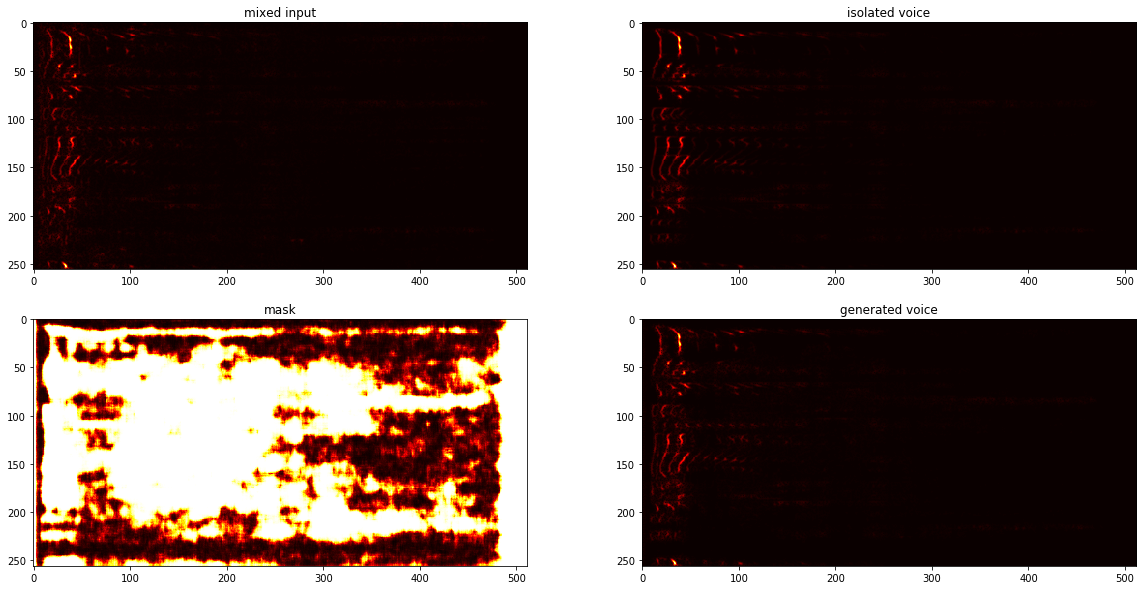

In [47]:
i=2

fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(mix_inp[i,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(voice_inp[i,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(mask[i,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(voice_est[i,:,:,0])
ax[1,1].set_title('generated voice')
plt.show()

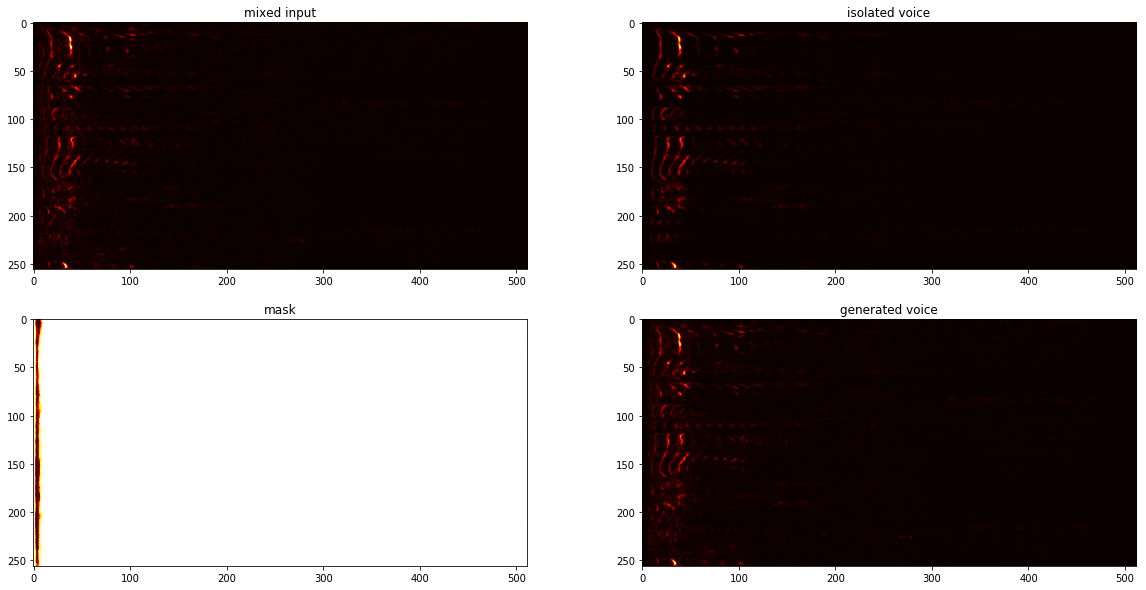

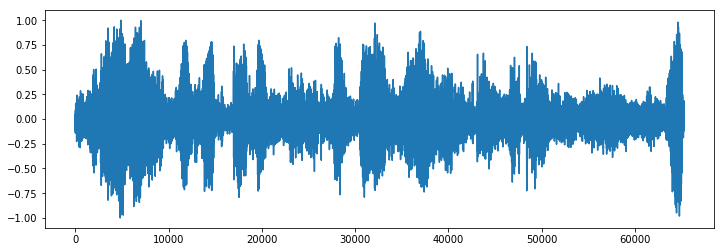

In [37]:
#  The original mixture
plt.figure(figsize=(12,4))
plt.plot(x,mix_wave[i])
ipd.Audio(mix_wave[i].T, rate=sample_rate)

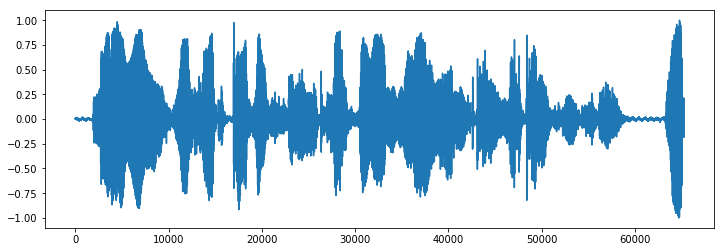

In [38]:
#  The original isolated voice
plt.figure(figsize=(12,4))
plt.plot(x,voice_wave[i])
ipd.Audio(voice_wave[i].T, rate=sample_rate)

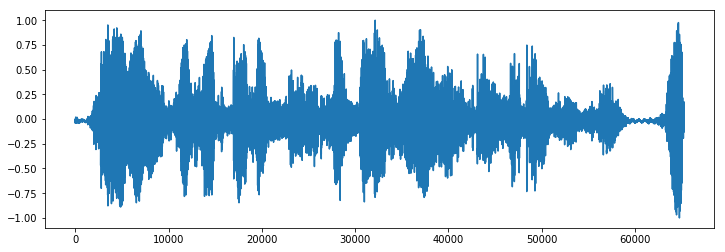

In [48]:
#  The estimated isolated voice produced by the network
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

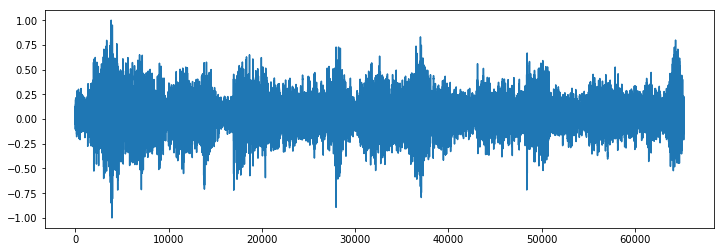

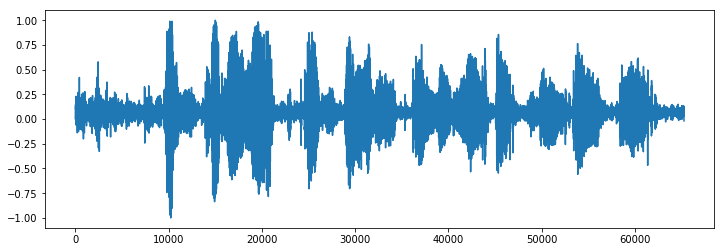

In [ ]:
#  The estimated isolated voice produced by the network
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

In [ ]:
#  The background noise, by subtracting the voice on the waveform - doesn't seem to work
#print(metrics['mix'])
plt.figure(figsize=(12,4))
plt.plot(x,bg_ref_wave[i])
ipd.Audio(bg_ref_wave[i].T, rate=sample_rate)

In [ ]:
#  The background noise, by subtracting magnitude spectrograms
plt.figure(figsize=(12,4))
plt.plot(x,bg_est_wave[i])
ipd.Audio(bg_est_wave[i].T, rate=sample_rate)

In [26]:
mask.shape

(5, 256, 512, 2)

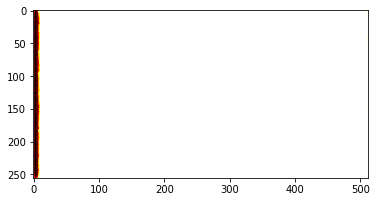

In [22]:
plt.imshow(mask[i,:,:,0])

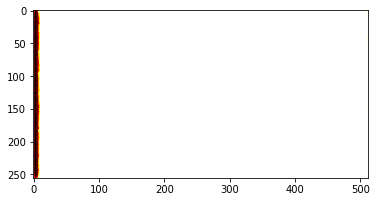

In [21]:
plt.imshow(mask[i,:,:,0])

In [42]:
sess.run(pipe.initializer)
print('start: {}'.format(datetime.now()))
epochs = 500
epoch = 0
epoch_cost = []
epoch_m_loss = []
epoch_p_loss = []
i = 0
while epoch < epochs:
    try:
        _, cost = sess.run([model.train_op, model.cost], {model.is_training:True})
        #_, cost, m_loss, p_loss = sess.run([model.train_op, model.cost, model.mag_loss, model.phase_loss], {model.is_training:True})
        #print('Iteration {i}: {dt}\nCost: {c}'.format(i=i, dt=datetime.datetime.now(), c=cost))
        epoch_cost.append(cost)
        #epoch_m_loss.append(m_loss)
        #epoch_p_loss.append(p_loss)
        i += 1
    except tf.errors.OutOfRangeError:
        epoch_mean_cost = sum(epoch_cost)/len(epoch_cost)
        #epoch_mean_m_loss = sum(epoch_m_loss)/len(epoch_m_loss)
        #epoch_mean_p_loss = sum(epoch_p_loss)/len(epoch_p_loss)
        print('Epoch {e} finished. Mean cost = {emc}'.format(e=epoch, emc=epoch_mean_cost))
        #print('\tMean magnitude loss = {emml}\n\tMean phase loss = {empl}'.format(emml=epoch_mean_m_loss,
        #                                                                       empl=epoch_mean_p_loss))
        epoch += 1
        sess.run(pipe.initializer)
print('finish: {}'.format(datetime.now()))

start: 2018-11-02 08:32:21.205386
Epoch 0 finished. Mean cost = 2.142683297279291e-05
Epoch 1 finished. Mean cost = 2.140473861800274e-05
Epoch 2 finished. Mean cost = 2.1378178644226864e-05
Epoch 3 finished. Mean cost = 2.135549766535405e-05
Epoch 4 finished. Mean cost = 2.1333471522666514e-05
Epoch 5 finished. Mean cost = 2.1315903723007068e-05
Epoch 6 finished. Mean cost = 2.1298956458589862e-05
Epoch 7 finished. Mean cost = 2.1283302658048342e-05
Epoch 8 finished. Mean cost = 2.126711135335629e-05
Epoch 9 finished. Mean cost = 2.1250496138236487e-05
Epoch 10 finished. Mean cost = 2.1234285172381945e-05
Epoch 11 finished. Mean cost = 2.12161946061921e-05
Epoch 12 finished. Mean cost = 2.119771684542334e-05
Epoch 13 finished. Mean cost = 2.11797062417775e-05
Epoch 14 finished. Mean cost = 2.116256133983067e-05
Epoch 15 finished. Mean cost = 2.114646542850096e-05
Epoch 16 finished. Mean cost = 2.1131602967644166e-05
Epoch 17 finished. Mean cost = 2.1117264117896815e-05
Epoch 18 finish

Epoch 152 finished. Mean cost = 1.816378062952567e-05
Epoch 153 finished. Mean cost = 1.8136202618131993e-05
Epoch 154 finished. Mean cost = 1.810890396647606e-05
Epoch 155 finished. Mean cost = 1.8081919034347476e-05
Epoch 156 finished. Mean cost = 1.805522749532284e-05
Epoch 157 finished. Mean cost = 1.8028875919172386e-05
Epoch 158 finished. Mean cost = 1.8002708757251542e-05
Epoch 159 finished. Mean cost = 1.7976718640966283e-05
Epoch 160 finished. Mean cost = 1.7950918133821055e-05
Epoch 161 finished. Mean cost = 1.7925569880861548e-05
Epoch 162 finished. Mean cost = 1.7900286840333496e-05
Epoch 163 finished. Mean cost = 1.7875252918135475e-05
Epoch 164 finished. Mean cost = 1.7850432849434474e-05
Epoch 165 finished. Mean cost = 1.7825936039850813e-05
Epoch 166 finished. Mean cost = 1.7801559997297626e-05
Epoch 167 finished. Mean cost = 1.777762900344117e-05
Epoch 168 finished. Mean cost = 1.77537792442093e-05
Epoch 169 finished. Mean cost = 1.773020263392348e-05
Epoch 170 finishe

Epoch 302 finished. Mean cost = 1.5831109311854468e-05
Epoch 303 finished. Mean cost = 1.5822584890955976e-05
Epoch 304 finished. Mean cost = 1.5814120593322364e-05
Epoch 305 finished. Mean cost = 1.5805688366336516e-05
Epoch 306 finished. Mean cost = 1.579728583172563e-05
Epoch 307 finished. Mean cost = 1.5788930267109362e-05
Epoch 308 finished. Mean cost = 1.5780644586655835e-05
Epoch 309 finished. Mean cost = 1.57723981095431e-05
Epoch 310 finished. Mean cost = 1.5764247261543072e-05
Epoch 311 finished. Mean cost = 1.5756120713096887e-05
Epoch 312 finished. Mean cost = 1.5748061892858628e-05
Epoch 313 finished. Mean cost = 1.5740003737458434e-05
Epoch 314 finished. Mean cost = 1.573199333217908e-05
Epoch 315 finished. Mean cost = 1.5724036745579517e-05
Epoch 316 finished. Mean cost = 1.571609998056764e-05
Epoch 317 finished. Mean cost = 1.5708247604454083e-05
Epoch 318 finished. Mean cost = 1.570043427262785e-05
Epoch 319 finished. Mean cost = 1.569265776879547e-05
Epoch 320 finishe

Epoch 452 finished. Mean cost = 1.4938485481123935e-05
Epoch 453 finished. Mean cost = 1.4934322554620044e-05
Epoch 454 finished. Mean cost = 1.4930166968782202e-05
Epoch 455 finished. Mean cost = 1.4926028416483492e-05
Epoch 456 finished. Mean cost = 1.4921907108309306e-05
Epoch 457 finished. Mean cost = 1.491780669240504e-05
Epoch 458 finished. Mean cost = 1.4913719815706397e-05
Epoch 459 finished. Mean cost = 1.4909645069169725e-05
Epoch 460 finished. Mean cost = 1.4905589926016791e-05
Epoch 461 finished. Mean cost = 1.4901546490844465e-05
Epoch 462 finished. Mean cost = 1.4897531577284508e-05
Epoch 463 finished. Mean cost = 1.4893523000566723e-05
Epoch 464 finished. Mean cost = 1.488952343655695e-05
Epoch 465 finished. Mean cost = 1.4885528068975775e-05
Epoch 466 finished. Mean cost = 1.4881567822898164e-05
Epoch 467 finished. Mean cost = 1.4877621558694862e-05
Epoch 468 finished. Mean cost = 1.4873690947742343e-05
Epoch 469 finished. Mean cost = 1.4869770595706018e-05
Epoch 470 fi